# Import Datasets

1.Facebook's stock price throughout 2018 (obtained using the stock_analysis package)

2. Earthquake data from September 18, 2018 - October 13, 2018 (obtained from the US Geological Survey (USGS) using the USGS API)
3. European Centre for Disease Prevention and Control's (ECDC) daily number of new reported cases of COVID-19 by country worldwide dataset collected on September 19, 2020 via this link

In [3]:
!pip install seaborn

You should consider upgrading via the 'd:\wtamu_summer1_2021\cidm-5310\pandas\code\ch_05\scripts\python.exe -m pip install --upgrade pip' command.


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

fb = pd.read_csv('./data/fb_stock_prices_2018.csv', index_col='date', parse_dates=True)
quakes = pd.read_csv('./data/earthquakes.csv')
covid = pd.read_csv('./data/covid19_cases.csv').assign(
    date=lambda x: pd.to_datetime(x.dateRep, format='%d/%m/%Y')
).set_index('date').replace(
    'United_States_of_America', 'USA'
).sort_index()['2020-01-18':'2020-09-18']

# Exercise 1
Using seaborn, create a heatmap to visualize the correlation coefficients between earthquake magnitude and whether there was a tsunami with the mb magnitude type.

Text(0.5, 1.01, 'Correlation between earthquake magnitude\nand whether there was a tsunami')

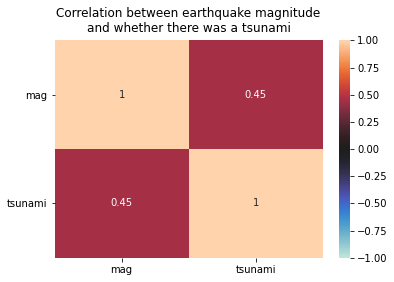

In [7]:
sns.heatmap(
    quakes.query('magType == "mb"')[['mag','tsunami']].corr(), 
    annot=True, center=0, vmin=-1, vmax=1
)
plt.yticks(rotation=0)
plt.title('Correlation between earthquake magnitude\nand whether there was a tsunami', y=1.01)

# Exercise 2
Create a box plot of Facebook volume traded and closing price and draw reference lines for the bounds of a Tukey fence with a multiplier of 1.5.

Text(0.5, 1.1, 'Facebook volume traded and closing price with Tukey Fence bounds')

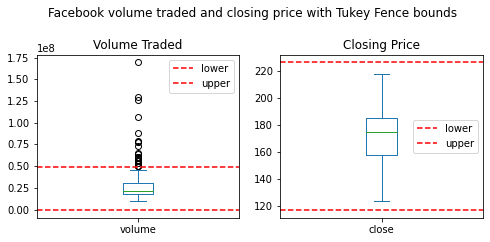

In [8]:
cols = ['volume', 'close']
subset = fb[cols]

quantiles = subset.quantile([0.25, 0.75])
quantiles.loc['iqr',:] = quantiles.loc[0.75,:] - quantiles.loc[0.25,:]

axes = subset.plot(kind='box', subplots=True, figsize=(8, 3), title=['Volume Traded', 'Closing Price'])
for ax, col in zip(axes, cols):
    stats = quantiles[col]
    lower = stats.loc[0.25] - 1.5 * stats['iqr']
    upper = stats.loc[0.75] + 1.5 * stats['iqr']
    for bound, name in zip([lower, upper], ['lower', 'upper']):
        ax.axhline(
            bound, 
            color='red', 
            linestyle='dashed',
            label=name
        )
        ax.legend()
plt.suptitle('Facebook volume traded and closing price with Tukey Fence bounds', y=1.1)

# Exercise 3
Plot the evolution of cumulative COVID-19 cases worldwide and add a dashed vertical line for on the date that it surpassed 1 million

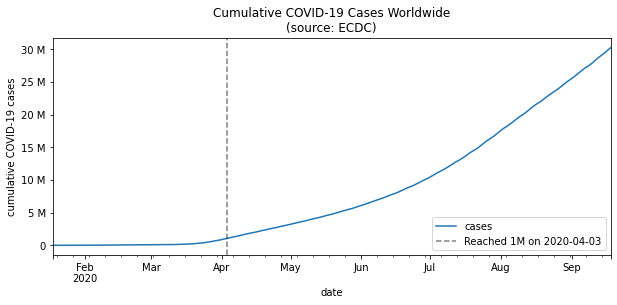

In [9]:
from matplotlib.ticker import EngFormatter

cumulative_cases = covid.groupby(pd.Grouper(freq='1D')).sum().cases.cumsum()

ax = cumulative_cases.plot(title='Cumulative COVID-19 Cases Worldwide\n(source: ECDC)', figsize=(10, 4))
ax.set_ylabel('cumulative COVID-19 cases')
ax.yaxis.set_major_formatter(EngFormatter())

over_1M = cumulative_cases[cumulative_cases >= 1e6].index[0]
ax.axvline(over_1M, linestyle='dashed', color='k', alpha=0.5, label=f"Reached 1M on {over_1M.strftime('%Y-%m-%d')}")

ax.legend()

# Exercise 4
Use axvspan() to shade a rectangle from '2018-07-25' to '2018-07-31' marking the large decline in Facebook price on a line plot of closing price.

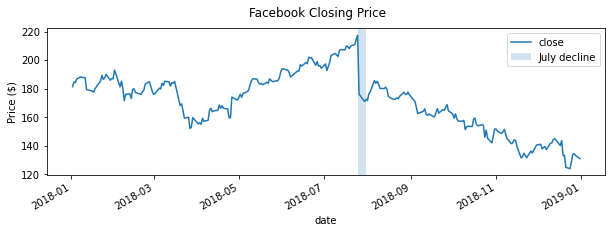

In [10]:
fb.close.plot(kind='line', figsize=(10, 3))
plt.axvspan(
    '2018-07-25', '2018-07-31', alpha=0.2, label='July decline',
)
plt.ylabel('Price ($)')
plt.suptitle('Facebook Closing Price')
plt.legend()

# Exercise 5
Using the Facebook stock data, annotate the following three events on a line graph of closing price:

'Disappointing user growth announced after close' on July 25, 2018
'Cambridge Analytica story breaks' on March 19, 2018 (when it affected the market)
'FTC launches investigation' on March 20, 2018

Text(0.5, 0.98, 'Facebook Closing Price')

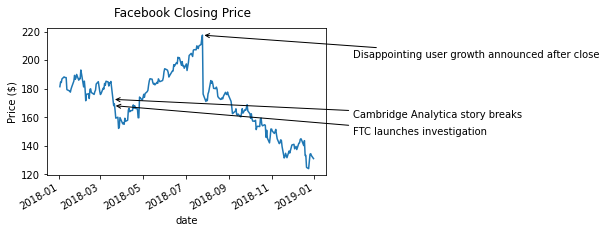

In [11]:
fb.close.plot(kind='line', figsize=(5, 3))

notes = [
    ('Disappointing user growth announced after close', '2018-07-25'),
    ('Cambridge Analytica story breaks', '2018-03-19'),
    ('FTC launches investigation', '2018-03-20')
]

# for repeatable random jitter
np.random.seed(1)

for text, date in notes:
    y_value = fb.close[date]
    jitter = np.random.uniform(-20, -10, 1)
    plt.annotate(
        text, 
        xy=(date, y_value),
        xytext=('2019-02-25', y_value + jitter),
        arrowprops=dict(arrowstyle='->')
    )
plt.ylabel('Price ($)')
plt.suptitle('Facebook Closing Price')

# Exercise 6
Modify the reg_resid_plot() function to use a matplotlib colormap instead of cycling between two colors. Remember, for this use case, you should pick a qualitative colormap or make your own.

[<AxesSubplot:xlabel='close', ylabel='volume'>,
 <AxesSubplot:xlabel='close', ylabel='residuals'>,
 <AxesSubplot:xlabel='volume', ylabel='close'>,
 <AxesSubplot:xlabel='volume', ylabel='residuals'>]

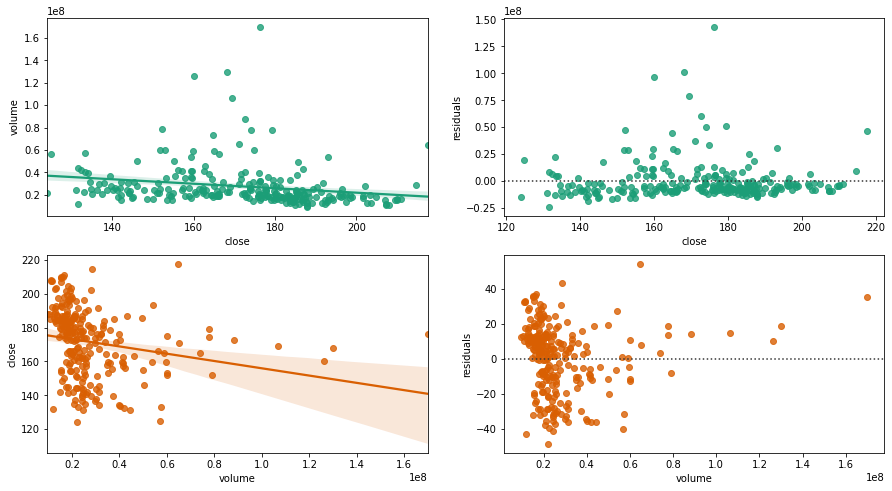

In [13]:
import itertools

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns


def reg_resid_plots(data):
    """
    Using `seaborn`, plot the regression and residuals
    plots side-by-side for every permutation of 2 columns 
    in the data.

    Parameters:
        - data: A `pandas.DataFrame` object

    Returns:
        A matplotlib `Axes` object.
    """
    num_cols = data.shape[1]
    permutation_count = num_cols * (num_cols - 1)

    fig, ax = plt.subplots(
        permutation_count, 
        2, 
        figsize=(15, 4 * permutation_count)
    )

    for (x, y), axes, color in zip(
        itertools.permutations(data.columns, 2), 
        ax,
        [cm.Dark2(i) for i in range(len(ax))]
    ):
        for subplot, func in zip(axes, (sns.regplot, sns.residplot)):
            func(x=x, y=y, data=data, ax=subplot, color=color)
            
            if func == sns.residplot:
                # mark the residuals as such
                subplot.set_ylabel('residuals')

    return fig.axes

reg_resid_plots(fb[['close', 'volume']])